<a href="https://colab.research.google.com/github/heba1518/handwriting_prescription_recognation/blob/main/handwriting_prescription_recognation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data collection

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

Preview how the dataset is organized. Lines prepended by "#" are just metadata information.

In [ ]:
!head -50 data/words.txt

## Imports

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset splitting

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples

)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


## Data input pipeline

preparing the image paths.

In [ ]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

prepare the ground-truth labels.

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

clean the validation and the test labels as well.

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion


In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)



### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

## Prepare `tf.data.Dataset` objects

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

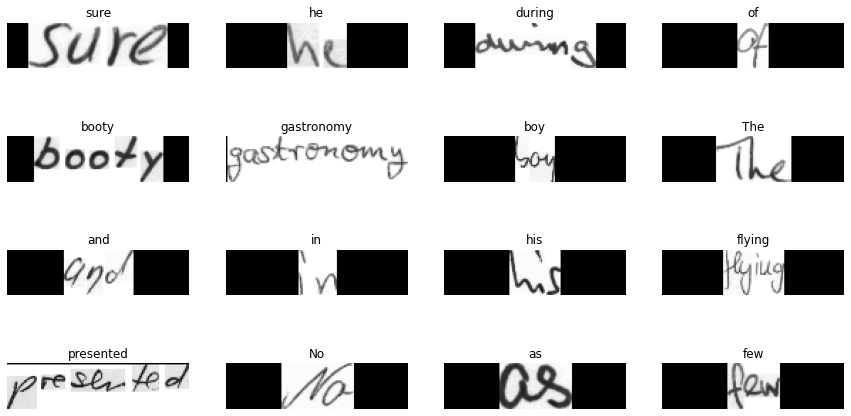

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

Our model will use the CTC loss as an endpoint layer.

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)


    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = keras.layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)
    x = keras.layers.Dropout(0.2)(x)
    #first max pooling layer
    x = keras.layers.Conv2D(
        1024,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv8",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    #second max pooling layer
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv7",
    )(x)


    # x=keras.layers.MaxPooling2D((2, 2), name="pool3")(x)
    # We have used two max pool with pool size and strides 2.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(1024, return_sequences=True, dropout=0.3)
    )(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(512, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.2)
    )(x)


    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 Conv4 (Conv2D)                 (None, 128, 32, 128  36992       ['Conv1[0][0]']                  
                                )                                                                 
                                                                             

## Evaluation metric


segregate the validation images and their labels for convenience.

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

create a callback to monitor the edit distances.

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

## Training


In [ ]:
epochs = 50  # To get good results this should be at least 50.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("handwriting.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb,early_stopping_cb,edit_distance_callback],
)

Epoch 1/40
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.2903
1357/1357 [==============================] - 382s 267ms/step - loss: 12.1774 - val_loss: 10.4314
Epoch 2/40
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 2: 18.5440
1357/1357 [==============================] - 351s 258ms/step - loss: 7.4119 - val_loss: 4.6196
Epoch 3/40
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 3: 17.6061
1357/1357 [==============================] - 350s 258ms/step - loss: 3.6920 - val_loss: 2.5111
Epoch 4/40
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 4: 17.5360
1357/1357 [==============================] - 349s 257ms/step - loss: 2.5211 - val_loss: 2.1408
Epoch 5/40
1/1 [==============================] - 0s 48ms/step
Mean edit distance for epoch 5: 17.5177
1357/1357 [==============================] - 350s 258ms/step - loss: 2.0179 - val_loss: 1.9649
Epoch 6/40

## Inference

len is :  2
batch img shape:  (128, 32, 1)
2/2 [==============================] - 0s 35ms/step
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)
(128, 32, 1)


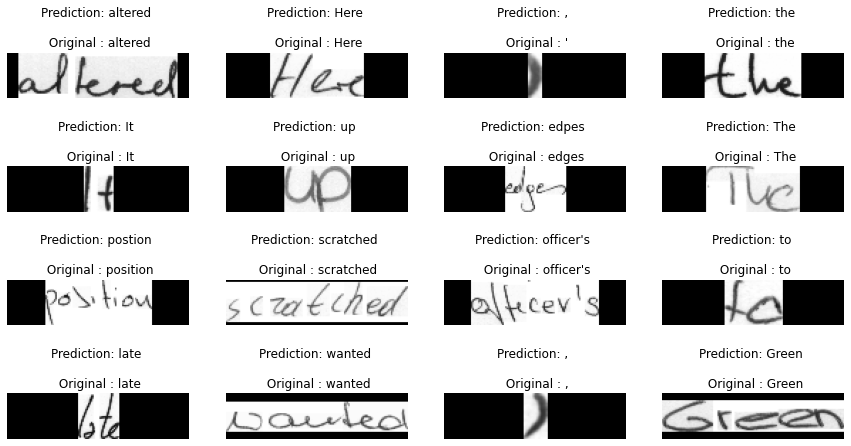

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    # print(batch["label"])
    batch_images,batch_labels = batch["image"],batch["label"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch_images[1].shape)
    # print(batch)
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        print(img.shape)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        title = f"Prediction: {pred_texts[i]} \n\n Original : {label}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
# Get predictions for the test dataset
all_preds = []
all_labels = []
for batch in test_ds:
    batch_images, batch_labels = batch["image"], batch["label"]
    preds = improved_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    all_preds.extend(pred_texts)
    all_labels.extend([tf.strings.reduce_join(num_to_char(tf.gather(label, tf.where(tf.math.not_equal(label, padding_token))))).numpy().decode("utf-8") for label in batch_labels])

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=characters)

# Plot confusion matrix
plt.figure(figsize=(36, 36))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=characters, yticklabels=characters)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate classification report
classification_rep = classification_report(all_labels, all_preds, labels=characters)

print("Classification Report:\n", classification_rep)
print(f"Accuracy : {accuracy}% ")

  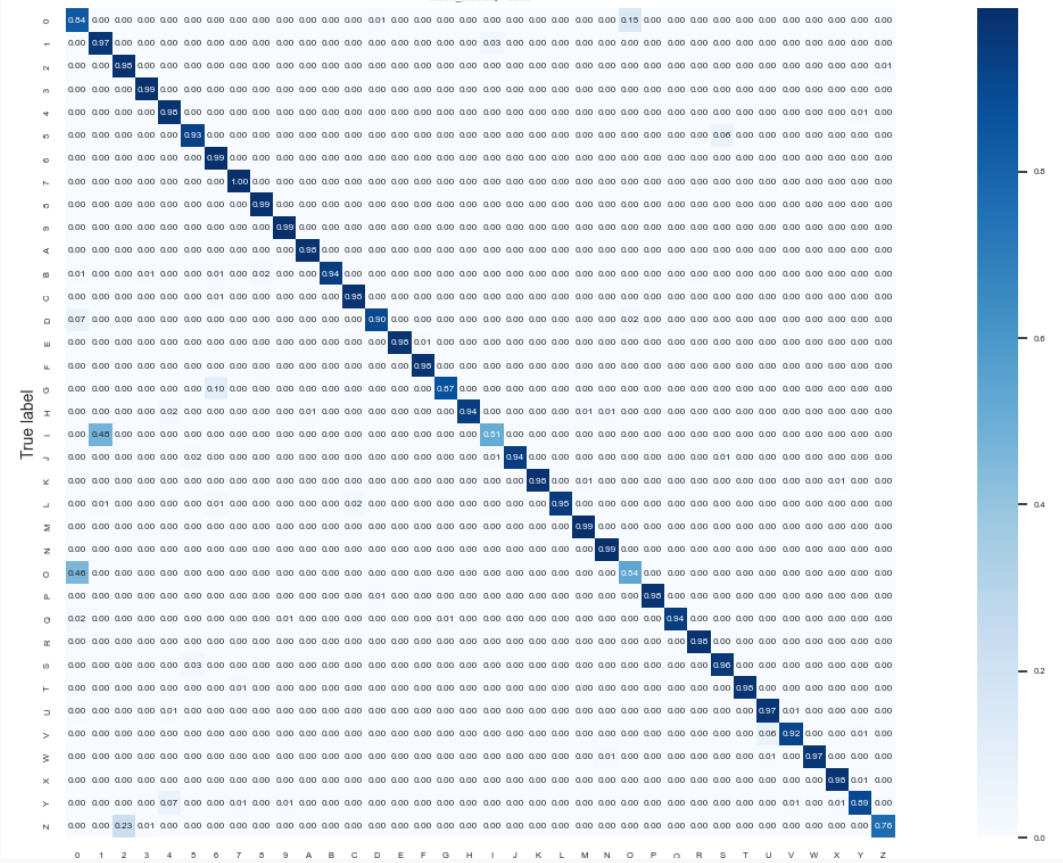


   Classification Report:

               precision    recall  f1-score   support

           !       1.00      0.73      0.84        11
           "       1.00      0.90      0.95        51
           #       0.00      0.00      0.00         1
           &       0.00      0.00      0.00         1
           '       0.00      0.00      0.00        15
           (       1.00      1.00      1.00         1
           )       0.50      0.67      0.57         6
           *       0.00      0.00      0.00         0
           +       0.00      0.00      0.00         0
           ,       0.87      0.97      0.92       239
           -       0.95      0.95      0.95        22
           .       0.95      0.95      0.95       202
           /       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
           :       1.00      0.89      0.94         9
           ;       1.00      0.90      0.95        10
           ?       1.00      1.00      1.00         6
           A       0.50      0.80      0.62         5
           B       0.00      0.00      0.00         0
           C       0.50      1.00      0.67         1
           D       0.00      0.00      0.00         1
           E       0.00      0.00      0.00         0
           F       0.00      0.00      0.00         0
           G       0.00      0.00      0.00         0
           H       0.00      0.00      0.00         0
           I       1.00      0.55      0.71        22
           J       0.00      0.00      0.00         0
           K       0.00      0.00      0.00         0
           L       0.00      0.00      0.00         0
           M       0.00      0.00      0.00         0
           N       0.00      0.00      0.00         0
           O       0.00      0.00      0.00         0
           P       0.00      0.00      0.00         0
           Q       0.00      0.00      0.00         0
           R       0.00      0.00      0.00         0
           S       0.00      0.00      0.00         0
           T       0.00      0.00      0.00         0
           U       0.00      0.00      0.00         0
           V       0.00      0.00      0.00         0
           W       0.00      0.00      0.00         0
           X       0.00      0.00      0.00         0
           Y       0.00      0.00      0.00         0
           Z       0.00      0.00      0.00         0
           a       0.97      0.98      0.98       101
           b       0.00      0.00      0.00         0
           c       0.00      0.00      0.00         0
           d       0.00      0.00      0.00         0
           e       0.00      0.00      0.00         0
           f       0.00      0.00      0.00         0
           g       0.00      0.00      0.00         0
           h       0.00      0.00      0.00         0
           i       0.00      0.00      0.00         0
           j       0.00      0.00      0.00         0
           k       0.00      0.00      0.00         0
           l       0.00      0.00      0.00         0
           m       0.00      0.00      0.00         0
           n       0.00      0.00      0.00         0
           o       0.00      0.00      0.00         0
           p       0.00      0.00      0.00         0
           q       0.00      0.00      0.00         0
           r       0.00      0.00      0.00         0
           s       0.00      0.00      0.00         0
           t       0.00      0.00      0.00         0
           u       0.00      0.00      0.00         0
           v       0.00      0.00      0.00         0
           w       0.00      0.00      0.00         0
           x       0.00      0.00      0.00         0
           y       0.00      0.00      0.00         0
           z       0.00      0.00      0.00         0
           micro avg       0.91      0.91      0.91       706
           macro avg       0.18      0.18      0.18       706
           weighted avg       0.90      0.91      0.90       706
           Accuracy : 81.104%

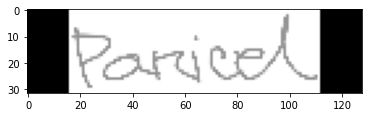

(32, 128)


In [ ]:
## custom image

img_path = "/content/custom_images/medicine1.jpg"
image2 = preprocess_image(img_path)
# label = vectorize_label(label)
img2 = tf.image.flip_left_right(image2)
img2 = tf.transpose(img2, perm=[1, 0, 2])
img2 = (img2 * 255.0).numpy().clip(0, 255).astype(np.uint8)
img2 = img2[:, :, 0]
plt.imshow(img2,cmap="gray")
plt.show()
img_list = [img2]
print(img2.shape)
# gathering text
# preds2 = prediction_model.predict(img_list)
# pred_texts2 = decode_batch_predictions(preds2)
# print(pred_texts2)

In [ ]:
def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


In [ ]:
img_paths_3 = ["/content/medicine1.jpg","/content/medicine2.jpg","/content/medicine3.jpg","/content/medicine4.jpg"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

len is :  5
batch img shape:  (128, 32, 1)
batch img shape:  (128, 32, 1)
1/1 [==============================] - 0s 49ms/step
['Parieel', 'Escum', 'Amlopin', 'Eelustat', 'Cakcin']


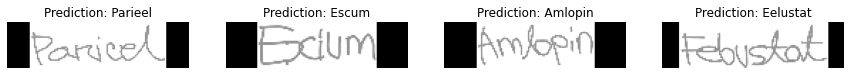

In [ ]:
for batch in custom_ds.take(1):
    # print(batch["label"])
    # print(batch)
    # batch_images = batch["image"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch[0].shape)
    print("batch img shape: ",batch[1].shape)

    _, ax = plt.subplots(1, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(4):
        img = batch[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()

In [ ]:
val_loss_list = history.history["val_loss"]
loss_list = history.history["loss"]

plot_list = range(1, len(val_loss_list) + 1)

plt.plot(plot_list, loss_list, label="Training Loss")
plt.plot(plot_list, val_loss_list, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

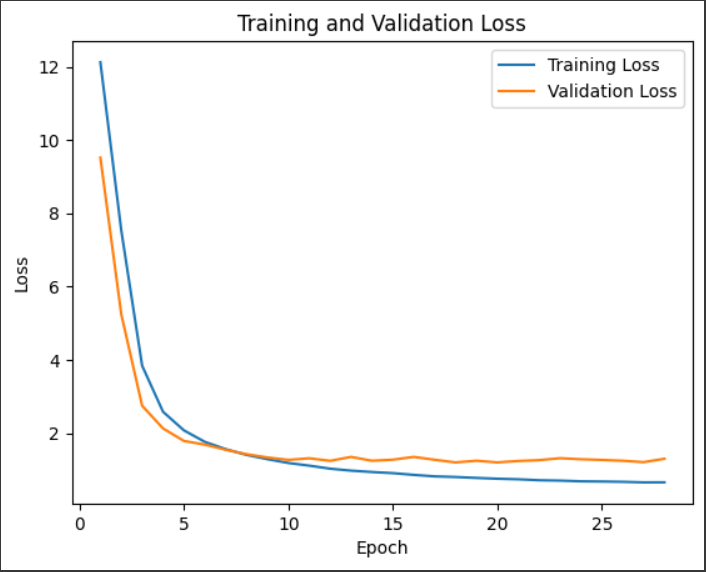